In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score


In [130]:
df = pd.read_csv('../data/df.csv',sep = ',')

In [131]:
df['Motif'] = df['Motif'].apply(lambda x : 3 if x == 'Motif tres mauvais' else 2 if x == 'Motif mauvais' else 1)

df['Situation_fam'] = df['Situation_fam'].apply(lambda x : 2 if x == 'Mauvaise situation' else 1)

df['Nature'] = df['Nature'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['Solution_echec'] = df['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)

df['Nature_op'] = df['Nature_op'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['MTF'] = df['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

df['ETAT_CIVIL'] = df['ETAT_CIVIL'].apply(lambda x : 2 if x == 'Mauvais etat' else 1)

df['CSP'] = df['CSP'].apply(lambda x : 2 if x == 'Mauvaise CSP' else 1)

In [132]:
df = df[['Motif', 'niv_gravite_mtf_dfs', 'MTF', 'dls_mep_entree_def',
       'ANC_PRO_MAX_PFI', 'nb_empr_ope', 'CD_DNE_CHR_LGD_SAIN', 'MT_EAD_RESID',
       'cum_dec', 'MT_REST_VIVRE', 'DET', 'arrete', 'cd_op']]

In [133]:
df['arrete'] = pd.to_datetime(df['arrete'])

In [134]:
df_validation = df[df['arrete']>"2020-12-30"]

In [135]:
data = df[df['arrete']<"2020-12-30"]

# train test 

In [136]:
# Sélectionner les données
X = data.copy() # On drop les var qui ont trop de NaN

X = X.select_dtypes(exclude = 'datetime')
X.dropna(inplace = True)

y = X['DET']

X.drop(columns = 'DET', inplace = True)


In [137]:
X.drop(columns = ['cd_op'], inplace = True)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimisation hyper parametres

In [145]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Assume X_train, X_test, y_train, y_test are defined

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 25, 150),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_prob)
    return roc_auc

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")


[I 2024-02-03 19:27:06,460] A new study created in memory with name: no-name-2de9bf44-f3c7-4bce-a6c3-f0e1067ffa2b
[I 2024-02-03 19:27:07,565] Trial 0 finished with value: 0.7838528522068904 and parameters: {'max_depth': 22, 'eta': 2.2409724914517377e-08, 'gamma': 2.1430124604657636e-08, 'colsample_bytree': 0.7674318219538889, 'subsample': 0.3402454977348136, 'n_estimators': 96}. Best is trial 0 with value: 0.7838528522068904.
[I 2024-02-03 19:27:08,745] Trial 1 finished with value: 0.7840679577257312 and parameters: {'max_depth': 20, 'eta': 5.943835440105696e-07, 'gamma': 1.895290118858563e-06, 'colsample_bytree': 0.5071533275003938, 'subsample': 0.8151211988910467, 'n_estimators': 88}. Best is trial 1 with value: 0.7840679577257312.
[I 2024-02-03 19:27:08,918] Trial 2 finished with value: 0.7612300344097838 and parameters: {'max_depth': 15, 'eta': 0.0036450785177093168, 'gamma': 0.07383211135318349, 'colsample_bytree': 0.01867408604338705, 'subsample': 0.30183308732935155, 'n_estimato

Best parameters: {'max_depth': 10, 'eta': 0.007227563435538392, 'gamma': 0.036030577496366734, 'colsample_bytree': 0.6410285403644554, 'subsample': 0.8497631804866869, 'n_estimators': 105}
Best AUC score: 0.7927715671679406


Best parameters: {'booster': 'dart', 'max_depth': 11, 'eta': 0.0015707570040851947, 'gamma': 0.01338955350785846, 'colsample_bytree': 0.5086577127913693, 'subsample': 0.5026165152122065, 'n_estimators': 142}
Best AUC score: 0.7929119536905505

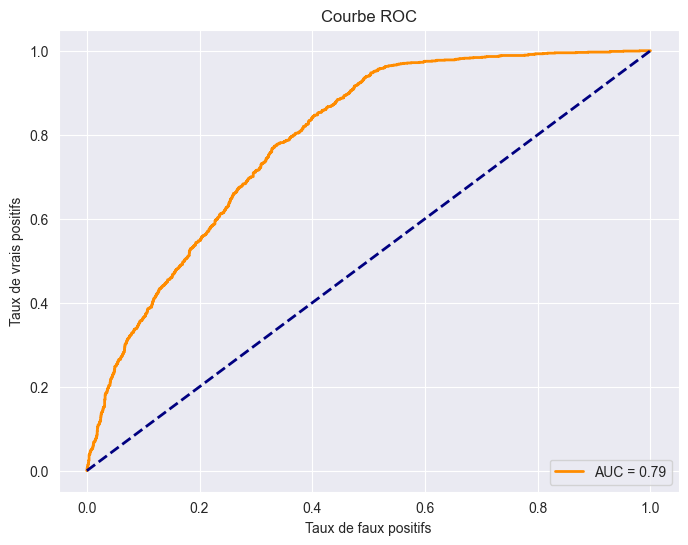

In [141]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

params = {'booster': 'gbtree', 'max_depth': 11, 'eta': 0.0015707570040851947, 'gamma': 0.01338955350785846, 'colsample_bytree': 0.5086577127913693, 'subsample': 0.5026165152122065, 'n_estimators': 142}


# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

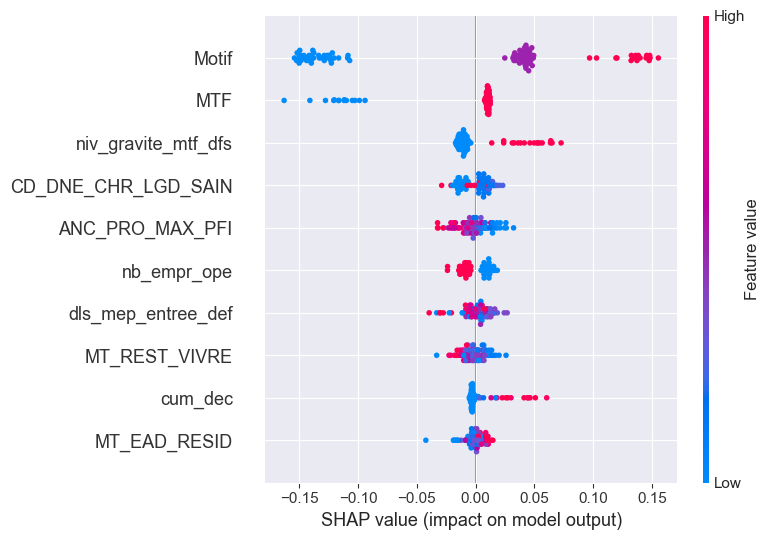

In [143]:
import shap


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train.iloc[:100, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train.iloc[:100, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [144]:
import numpy as np
# Les Shapley values pour chaque variable sont accessibles via l'attribut "values" du résultat de la fonction shap_values.
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]

# Afficher les n variables les plus importantes (par exemple, n=5)
n_top_variables = 10
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

# Imprimer la liste des variables les plus importantes
top_variables

Index(['Motif', 'MTF', 'niv_gravite_mtf_dfs', 'CD_DNE_CHR_LGD_SAIN',
       'ANC_PRO_MAX_PFI', 'nb_empr_ope', 'dls_mep_entree_def', 'MT_REST_VIVRE',
       'cum_dec', 'MT_EAD_RESID'],
      dtype='object')